In [2]:
import numpy as np
import pickle, gzip
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import seaborn as sns

def show(image):
    plt.figure(figsize=(10,10))
    new = image.copy()
    if image.shape == 3:                    # Switch R and B channels so it shows up as correctly as R,G,B, if image is 3-channel
        new[:,:,0] = image[:,:,2]
        new[:,:,2] = image[:,:,0]
    plt.imshow(new, cmap = "gray")

# Set seed for reproducibility
np.random.seed(0)

### Load data

In [3]:
# Load MNIST data

with gzip.open('mnist.pkl.gz', 'rb') as f:
    training_data, validation_data, test_data = pickle.load(f, encoding="latin1")
    # training_data: tuple of (x_train, y_train), where x_train.shape = (50000, 784) and y_train.shape = (50000, 1)
    # validation_data: tuple of (x_val, y_val), where x_val.shape = (10000, 784) and y_val.shape = (10000, 1)
    # test_data: tuple of (x_test, y_test), where x_test.shape = (10000, 784) and y_test.shape = (10000, 1)

x_train, y_train = training_data
x_val, y_val = validation_data
x_test, y_test = test_data

# Combine training and validation data
x_train = np.concatenate((x_train, x_val), axis=0)
y_train = np.concatenate((y_train, y_val), axis=0)

# Reshape x
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

# One-hot encode labels
y_train = np.eye(10)[y_train].reshape((-1, 10, 1))
y_test = np.eye(10)[y_test].reshape((-1, 10, 1))

# Zip data and labels into tuples
train_data = list(zip(x_train, y_train))
test_data = list(zip(x_test, y_test))

# Shuffle training data
np.random.shuffle(train_data)

### Model constructor

In [4]:
# Constructor for neural network
# Adapted from Nielsen textbook http://neuralnetworksanddeeplearning.com/chap1.html

class Model(object):

    # Fully connected neural network with layer i having sizes[i] neurons
    def __init__(self, sizes, weights=None, biases=None):
        self.num_layers = len(sizes)
        self.sizes = sizes

        # Initialize weights & biases if not provided
        if weights is None:
            self.weights = [np.random.randn(y, x) for y, x in zip(sizes[1:], sizes[:-1])] # Initialize weights array of shape (num_neurons_i, num_neurons_i-1) for each layer i except the input layer
        else:
            self.weights = weights
        
        if biases is None:
            self.biases = [np.random.randn(y, 1) for y in sizes[1:]] # Initialize biases array of shape (num_neurons_i, 1) for each layer i except the input layer
        else:
            self.biases = biases

        # Initialize training history
        self.history = {'train': {'acc':[], 'loss':[]}, 'val': {'acc':[], 'loss':[]}, 'latent':[]}

        # Number of parameters
        print(f'Number of model parameters: {sum(np.prod(w.shape) for w in self.weights) + sum(np.prod(b.shape) for b in self.biases)}')

    # Activation functions
    def activation(self, x):
        # x is a vector of length num_hidden_neurons generated by hidden layer affine transformation
        def sigmoid(x):
            # Overflow-safe sigmoid function (https://timvieira.github.io/blog/post/2014/02/11/exp-normalize-trick/)
            if x > 0:
                return 1 / (1 + np.exp(-x))
            else:
                return np.exp(x) / (1 + np.exp(x))
        return np.array(list(map(sigmoid, x)))

    # Derivative of activation function
    def activation_der(self, x):
        return self.activation(x) * (1 - self.activation(x))

    # # Softmax function
    # # Overflow-safe softmax function (https://timvieira.github.io/blog/post/2014/02/11/exp-normalize-trick/)
    # def softmax(self, x):
    #     # x is unnormalized vector of length output_size generated by output layer affine transformation
    #     return np.exp(x - x.max()) / np.sum(np.exp(x - x.max()), axis=0)

    # Loss function
    def loss(self, y_true, y_pred):
        return np.mean(((y_true - y_pred)**2)) # mean squared error

    # Derivative of loss function
    def loss_der(self, y_true, y_pred):
        return 2*(y_pred - y_true)

    # Backpropagation
    # Input x,y is single training example
    # Returns (nabla_b, nabla_w), where nabla_b is list of gradients of cost with respect to biases (one for each layer) and nabla_w is list of gradients of cost with respect to weights (one for each layer)
    def backprop(self, x, y):
        # Initialize lists of gradients for each layer
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        
        ###### Forward pass, storing weighted inputs (z) and activations for each layer ######
        activation = x # Initialize activation with input
        activations = [x] # list to store all the activations, layer by layer
        zs = [] # list to store all the weighted input z vectors, layer by layer
        # Iterate through each layer
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation) + b # Compute weighted input z
            zs.append(z) # Store weighted input z
            activation = self.activation(z) # Compute activation
            activations.append(activation) # Store activation

        ###### Backward pass ######
        # Get gradients for output layer
        delta = self.loss_der(y, activations[-1]) * self.activation_der(zs[-1]) # Hadamard product of loss gradient and activation derivative
        nabla_b[-1] = delta # Store gradient of cost with respect to biases of last layer
        nabla_w[-1] = np.dot(delta, activations[-2].transpose()) # Store gradient of cost with respect to weights of last layer
        # Iterate through each layer in reverse order, starting from second to last layer
        for l in range(2, self.num_layers):
            z = zs[-l] # Retrieve weighted input z for current layer
            delta = np.dot(self.weights[-l+1].transpose(), delta) * self.activation_der(z) # Compute gradient of cost with respect to weighted input z
            nabla_b[-l] = delta # Store gradient of cost with respect to biases of current layer
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose()) # Store gradient of cost with respect to weights of current layer

        # Get training performance
        acc = int(np.argmax(y) == np.argmax(activations[-1])) # Whether predicted label is equal to true label
        loss = self.loss(y, activations[-1]) # Compute loss

        return nabla_b, nabla_w, acc, loss

    # Model training using SGD
    # training_data is a list of tuples (x, y) representing the training inputs and the desired outputs
    def fit(self, training_data, epochs = 10, batch_size = 10, learning_rate = 1.5, validation_size=0.3, shuffle_order=None, store_latent_vecs=False):
        
        # Take last portion of training data as validation data
        training_data = training_data[:-int(validation_size*len(training_data))]
        val_data = training_data[-int(validation_size*len(training_data)):]

        ## Store baseline model characteristics (before training)
        # Evaluate model on validation data
        val_acc, val_loss = self.evaluate(val_data)
        print(f"Baseline characteristics: Validation accuracy: {val_acc}. Mean validation loss: {val_loss}")
        # Update global history
        self.history['train']['acc'].append(np.nan)
        self.history['train']['loss'].append(np.nan)
        self.history['val']['acc'].append(val_acc)
        self.history['val']['loss'].append(val_loss)
        # Store latent vectors
        if store_latent_vecs:
            self.history['latent'].append([(self.feedforward(x, layer_num = 2), np.argmax(y)) for x, y in training_data]) # Store latent representation of training data before training

        # Iterate through each epoch
        print(f'Training on {len(training_data)} examples, validating on {len(val_data)} examples')
        for j in range(epochs):
            # Initialize epoch training accuracy and loss history
            train_acc = []
            train_loss = []

            # Shuffle training data in preparation for SGD batching
            if shuffle_order is None:
                np.random.shuffle(training_data) # Shuffle training data randomly
            else:
                training_data = training_data[shuffle_order[j]] # Shuffle training data according to order provided
            # Construct training batches for SGD
            batches = [training_data[k:k+batch_size] for k in range(0, len(training_data), batch_size)]
            # Iterate through all batches
            for batch in batches:
                nabla_b = [np.zeros(b.shape) for b in self.biases] # Initialize list of loss gradients with respect to biases, one gradient for each layer
                nabla_w = [np.zeros(w.shape) for w in self.weights] # Initialize list of loss gradients with respect to weights, one gradient for each layer
                # Iterate through all training examples in batch
                for x, y in batch:
                    delta_nabla_b, delta_nabla_w, acc, loss = self.backprop(x, y) # Compute loss gradients for each layer for single training example
                    nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)] # Accumulate bias loss gradients over batches for each layer
                    nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)] # Accumulate weight loss gradients over batches for each layer
                    # Update epoch training accuracy and loss history for single training example
                    train_acc.append(acc)
                    train_loss.append(loss)
                
                # Update weights and biases for each layer using average accumulated loss gradients
                self.weights = [w-(learning_rate/len(batch))*nw for w, nw in zip(self.weights, nabla_w)]
                self.biases = [b-(learning_rate/len(batch))*nb for b, nb in zip(self.biases, nabla_b)]
            
            # Compute epoch training accuracy and loss
            train_acc, train_loss = np.mean(train_acc), np.mean(train_loss)
            # Evaluate model on validation data
            val_acc, val_loss = self.evaluate(val_data)
            print(f"Epoch {j+1} complete.") # Print epoch number (epochs start at 1)
            print(f"Training accuracy: {train_acc}. Validation accuracy: {val_acc}. Mean training loss: {train_loss}. Mean validation loss: {val_loss}")

            # Update global history
            self.history['train']['acc'].append(train_acc)
            self.history['train']['loss'].append(train_loss)
            self.history['val']['acc'].append(val_acc)
            self.history['val']['loss'].append(val_loss)
            # Store latent vectors
            if store_latent_vecs:
                self.history['latent'].append([(self.feedforward(x, layer_num = 2), np.argmax(y)) for x, y in training_data]) # Store latent representation of training data after each epoch


    def evaluate(self, test_data):
        test_results = [(np.argmax(self.feedforward(x)), np.argmax(y)) for (x, y) in test_data]
        acc = sum(int(y_pred == y_true) for (y_pred, y_true) in test_results)/len(test_results)
        loss = np.mean([self.loss(self.feedforward(x), y) for (x, y) in test_data])

        return acc, loss

    # Get feedforward activations for given layer (default is last layer)
    # Equivalent to Tensorflow get_layer()
    def feedforward(self, x, layer_num = None):
        # Dynamically update activations for each layer while moving forward through the network, starting with shape (input_size, 1) and ending with shape (output_size, 1)
        if layer_num is None:
            layer_num = self.num_layers - 1
        activations = x
        current_layer = 1
        while current_layer <= layer_num:
            activations = self.activation(np.dot(self.weights[current_layer - 1], activations) + self.biases[current_layer - 1])
            current_layer += 1
        return activations

### Set global stochastic params

In [6]:
# Model architecture
sizes = [784, 30, 2, 10]
epochs = 10
batch_size = 10
learning_rate = 1.5
validation_size=0.3

# Initialize weights array of shape (num_neurons_i, num_neurons_i-1) for each layer i except the input layer
weights = [np.random.randn(y, x) for y, x in zip(sizes[1:], sizes[:-1])]

# Initialize biases array of shape (num_neurons_i, 1) for each layer i except the input layer
biases = [np.random.randn(y, 1) for y in sizes[1:]] 

# Initialize list of data indices for data shuffling per epoch
shuffle_order = [np.random.permutation(int(len(training_data)*(1 - validation_size))) for i in range(epochs)]

print(shuffle_order[0])
print(shuffle_order[1])

[0]
[0]


In [8]:
np.random.permutation(6)

array([0, 1, 2, 5, 3, 4])

In [13]:
# Build & train model
model1 = Model([784, 30, 10, 2, 10])
model1.fit(train_data, epochs = 10, batch_size = 10, learning_rate = 1.5, validation_size = 0.3)
test_acc, test_loss = model1.evaluate(test_data)
print(f'Test accuracy: {test_acc}. Mean test loss: {test_loss}')

Number of model parameters: 23912
Training on 42000 examples, validating on 12600 examples
Epoch 0 complete.
Training accuracy: 0.4134761904761905. Validation accuracy: 0.604047619047619. Mean training loss: 0.07068121680487852. Mean validation loss: 0.05700802112525756
Epoch 1 complete.
Training accuracy: 0.6491428571428571. Validation accuracy: 0.7201587301587301. Mean training loss: 0.05297099772601485. Mean validation loss: 0.04836836398575748
Epoch 2 complete.
Training accuracy: 0.7044285714285714. Validation accuracy: 0.7337301587301587. Mean training loss: 0.0469529403611096. Mean validation loss: 0.043325083652943394
Epoch 3 complete.
Training accuracy: 0.7192380952380952. Validation accuracy: 0.7388888888888889. Mean training loss: 0.04335308110625667. Mean validation loss: 0.04105141744363734
Epoch 4 complete.
Training accuracy: 0.7248333333333333. Validation accuracy: 0.6504761904761904. Mean training loss: 0.041866269490979685. Mean validation loss: 0.054127774469523895
Epo

In [8]:
# Build & train model
model2 = Model([784, 28, 10, 2, 10])
model2.fit(train_data, epochs = 10, batch_size = 10, learning_rate = 1.5, validation_size = 0.3)
test_acc, test_loss = model2.evaluate(test_data)
print(f'Test accuracy: {test_acc}. Mean test loss: {test_loss}')

Number of model parameters: 22322
Training on 42000 examples, validating on 12600 examples
Epoch 0 complete.
Training accuracy: 0.37183333333333335. Validation accuracy: 0.5565079365079365. Mean training loss: 0.07132357935198216. Mean validation loss: 0.05838244043192125
Epoch 1 complete.
Training accuracy: 0.5915. Validation accuracy: 0.6446825396825396. Mean training loss: 0.05452768428537634. Mean validation loss: 0.04936111120856152
Epoch 2 complete.
Training accuracy: 0.6438571428571429. Validation accuracy: 0.5164285714285715. Mean training loss: 0.04820394369117258. Mean validation loss: 0.053799897070450534
Epoch 3 complete.
Training accuracy: 0.6786904761904762. Validation accuracy: 0.6497619047619048. Mean training loss: 0.04521169291300793. Mean validation loss: 0.05014930230607851
Epoch 4 complete.
Training accuracy: 0.7299761904761904. Validation accuracy: 0.7255555555555555. Mean training loss: 0.04117935474703131. Mean validation loss: 0.03985790235622037
Epoch 5 comple

In [43]:
# Build & train model
model3 = Model([784, 28, 28, 2, 10])
model3.fit(train_data, epochs = 10, batch_size = 10, learning_rate = 1.5, validation_size = 0.3)
test_acc, test_loss = model3.evaluate(test_data)
print(f'Test accuracy: {test_acc}. Mean test loss: {test_loss}')

Number of model parameters: 22880
Training on 42000 examples, validating on 12600 examples
Epoch 0 complete.
Training accuracy: 0.3012142857142857. Validation accuracy: 0.4496825396825397. Mean training loss: 0.07590281158489101. Mean validation loss: 0.06290515832677353
Epoch 1 complete.
Training accuracy: 0.5260238095238096. Validation accuracy: 0.5257936507936508. Mean training loss: 0.058143048110853655. Mean validation loss: 0.05718229295276149
Epoch 2 complete.
Training accuracy: 0.6595. Validation accuracy: 0.7177777777777777. Mean training loss: 0.04878780700646764. Mean validation loss: 0.04456668121616193
Epoch 3 complete.
Training accuracy: 0.72. Validation accuracy: 0.7457936507936508. Mean training loss: 0.043347256660669714. Mean validation loss: 0.04296015608627704
Epoch 4 complete.
Training accuracy: 0.7282380952380952. Validation accuracy: 0.7416666666666667. Mean training loss: 0.04191678890548798. Mean validation loss: 0.040986395929127305
Epoch 5 complete.
Training 

In [48]:
# Build & train model
model4 = Model([784, 28, 2, 10])
model4.fit(train_data, epochs = 10, batch_size = 10, learning_rate = 1.5, validation_size = 0.3)
test_acc, test_loss = model4.evaluate(test_data)
print(f'Test accuracy: {test_acc}. Mean test loss: {test_loss}')

Number of model parameters: 22068
Baseline characteristics: Validation accuracy: 0.10015873015873016. Mean validation loss: 0.3735039608200381
Training on 42000 examples, validating on 12600 examples
Epoch 0 complete.
Training accuracy: 0.4062857142857143. Validation accuracy: 0.501984126984127. Mean training loss: 0.06835532546041352. Mean validation loss: 0.060000017614974706
Epoch 1 complete.
Training accuracy: 0.5161666666666667. Validation accuracy: 0.46214285714285713. Mean training loss: 0.05866850847837913. Mean validation loss: 0.05890250850852263
Epoch 2 complete.
Training accuracy: 0.5746428571428571. Validation accuracy: 0.6030952380952381. Mean training loss: 0.05629084870270852. Mean validation loss: 0.053922816314123434
Epoch 3 complete.
Training accuracy: 0.6135. Validation accuracy: 0.628968253968254. Mean training loss: 0.053260958876237725. Mean validation loss: 0.05154816714220936
Epoch 4 complete.
Training accuracy: 0.6578333333333334. Validation accuracy: 0.695476

KeyboardInterrupt: 

In [23]:
# Build & train model
model5 = Model([784, 28, 2, 10])
model5.fit(train_data, epochs = 30, batch_size = 10, learning_rate = 1, validation_size = 0.3)
test_acc, test_loss = model5.evaluate(test_data)
print(f'Test accuracy: {test_acc}. Mean test loss: {test_loss}')

Number of model parameters: 22068
Training on 42000 examples, validating on 12600 examples
Epoch 0 complete.
Training accuracy: 0.29588095238095236. Validation accuracy: 0.42373015873015873. Mean training loss: 0.07707146224973369. Mean validation loss: 0.06486915424179332
Epoch 1 complete.
Training accuracy: 0.47704761904761905. Validation accuracy: 0.557063492063492. Mean training loss: 0.06198496408927227. Mean validation loss: 0.059348792434360594
Epoch 2 complete.
Training accuracy: 0.5511428571428572. Validation accuracy: 0.557063492063492. Mean training loss: 0.05807406687690311. Mean validation loss: 0.05668957818396801
Epoch 3 complete.
Training accuracy: 0.5748333333333333. Validation accuracy: 0.5637301587301587. Mean training loss: 0.056282171041769885. Mean validation loss: 0.05644300121651215
Epoch 4 complete.
Training accuracy: 0.5849285714285715. Validation accuracy: 0.5920634920634921. Mean training loss: 0.055267852906174045. Mean validation loss: 0.05437556261244235


In [21]:
# Build & train model
model6 = Model([784, 28, 10, 2, 10])
model6.fit(train_data, epochs = 10, batch_size = 10, learning_rate = 1.5, validation_size = 0.3)
test_acc, test_loss = model6.evaluate(test_data)
print(f'Test accuracy: {test_acc}. Mean test loss: {test_loss}')

Number of model parameters: 22322
Training on 42000 examples, validating on 12600 examples
Epoch 0 complete.
Training accuracy: 0.4407142857142857. Validation accuracy: 0.5446031746031746. Mean training loss: 0.06596597620324979. Mean validation loss: 0.055358693883868396
Epoch 1 complete.
Training accuracy: 0.562952380952381. Validation accuracy: 0.5835714285714285. Mean training loss: 0.05190367286012126. Mean validation loss: 0.05004872028857797
Epoch 2 complete.
Training accuracy: 0.5705. Validation accuracy: 0.5777777777777777. Mean training loss: 0.04916981992835142. Mean validation loss: 0.05029092690143954
Epoch 3 complete.
Training accuracy: 0.5859761904761904. Validation accuracy: 0.6543650793650794. Mean training loss: 0.04721925942051985. Mean validation loss: 0.04613952861699601
Epoch 4 complete.
Training accuracy: 0.6617857142857143. Validation accuracy: 0.682936507936508. Mean training loss: 0.04477068759495955. Mean validation loss: 0.04421172822353432
Epoch 5 complete.

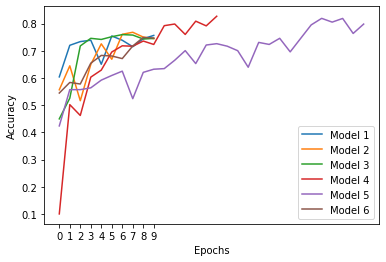

In [49]:
# Plot accuracy history
plt.plot(range(len(model1.history['val']['acc'])), model1.history['val']['acc'], label='Model 1')
plt.plot(range(len(model2.history['val']['acc'])), model2.history['val']['acc'], label='Model 2')
plt.plot(range(len(model3.history['val']['acc'])), model3.history['val']['acc'], label='Model 3')
plt.plot(range(len(model4.history['val']['acc'])), model4.history['val']['acc'], label='Model 4')
plt.plot(range(len(model5.history['val']['acc'])), model5.history['val']['acc'], label='Model 5')
plt.plot(range(len(model6.history['val']['acc'])), model6.history['val']['acc'], label='Model 6')
plt.xticks(np.arange(0, len(model1.history['val']['acc']), 1)) # Set xticks
plt.ylabel('Accuracy') # Y axis label
plt.xlabel('Epochs') # X axis label
plt.legend() # Add legend
plt.show();

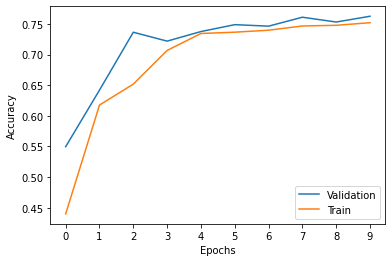

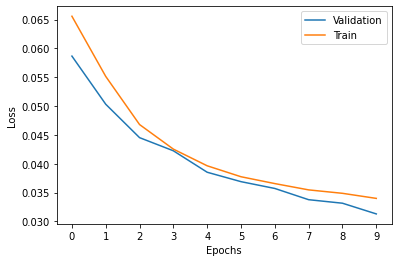

In [5]:
# # Plot accuracy history
# plt.plot(range(len(model.history['val']['acc'])), model.history['val']['acc'], label='Validation')
# plt.plot(range(len(model.history['train']['acc'])), model.history['train']['acc'], label='Train')
# plt.xticks(np.arange(0, len(model.history['val']['acc']), 1)) # Set xticks
# plt.ylabel('Accuracy') # Y axis label
# plt.xlabel('Epochs') # X axis label
# plt.legend() # Add legend
# plt.show();

# # Plot loss history
# plt.plot(range(len(model.history['val']['loss'])), model.history['val']['loss'], label='Validation')
# plt.plot(range(len(model.history['train']['loss'])), model.history['train']['loss'], label='Train')
# plt.xticks(np.arange(0, len(model.history['val']['loss']), 1)) # Set xticks
# plt.ylabel('Loss') # Y axis label
# plt.xlabel('Epochs') # X axis label
# plt.legend() # Add legend
# plt.show();

Plotting 60000 examples.


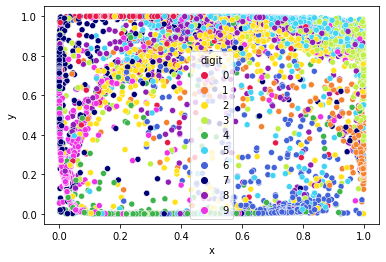

In [6]:
# # Get list of layer activations (latent vectors) for bottleneck layer for training data
# latent_vecs = [model.feedforward(x, layer_num = 3) for x, y in train_data]

# # Create dataframe
# df = []
# for index, vec in enumerate(latent_vecs):
#     df.append({'x': vec[0][0], 'y': vec[1][0], 'digit': np.argmax(train_data[index][1])})
# df = pd.DataFrame(df)

# # Plot latent vectors in 2D, color-coded by digit
# print(f'Plotting {len(df)} examples.')
# colors = sns.color_palette(['#e6194B','#f58231','#ffe119','#bfef45','#3cb44b','#42d4f4','#4363d8', '#000075', '#911eb4','#f032e6'])
# sns.scatterplot(data=df, x="x", y="y", hue="digit", palette=colors);

Plotting 42000 examples.


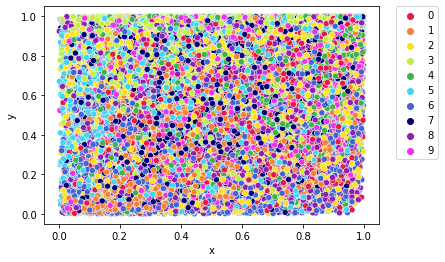

Plotting 42000 examples.


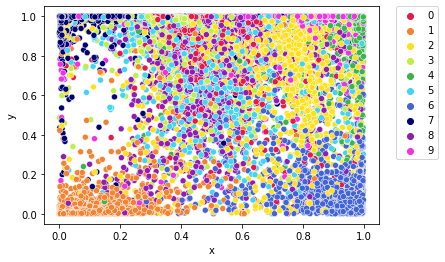

Plotting 42000 examples.


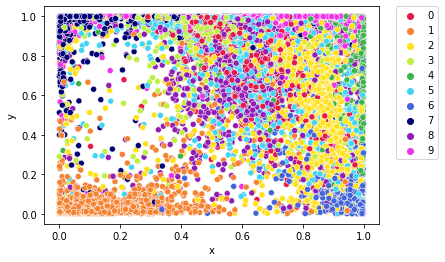

Plotting 42000 examples.


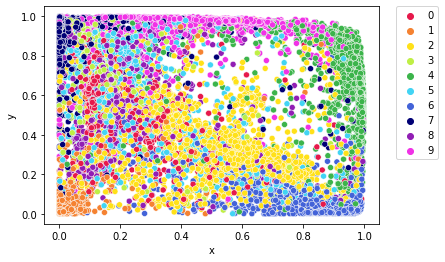

Plotting 42000 examples.


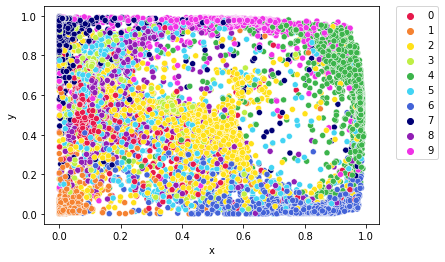

Plotting 42000 examples.


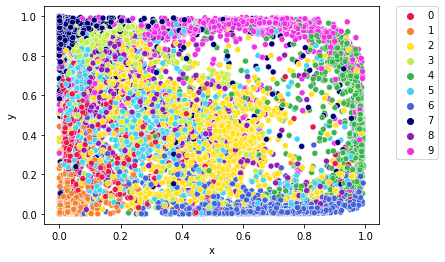

Plotting 42000 examples.


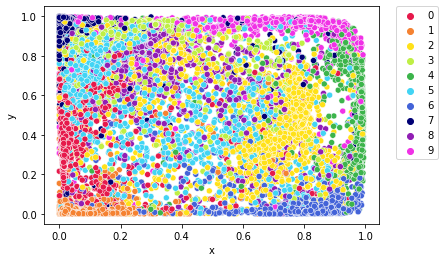

Plotting 42000 examples.


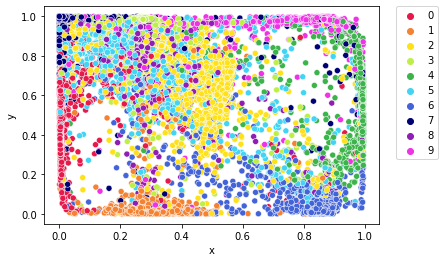

Plotting 42000 examples.


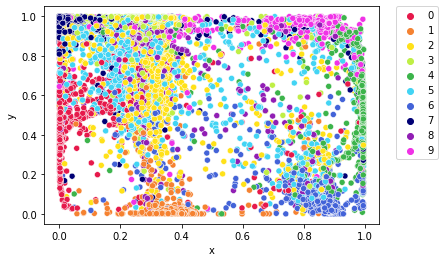

Plotting 42000 examples.


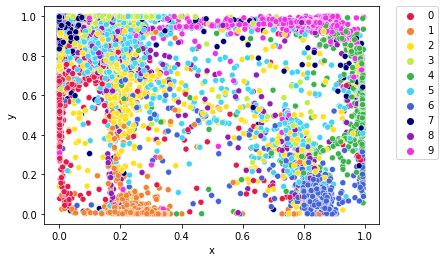

Plotting 42000 examples.


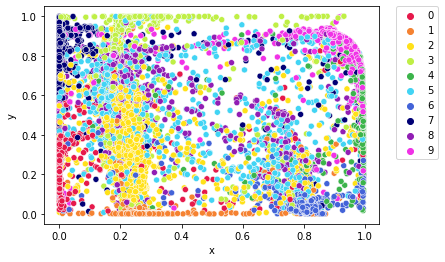

Plotting 42000 examples.


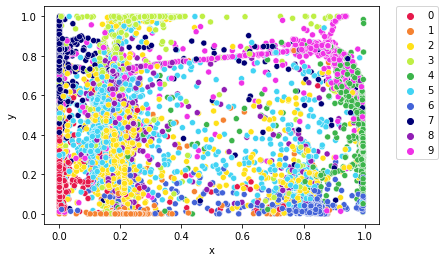

Plotting 42000 examples.


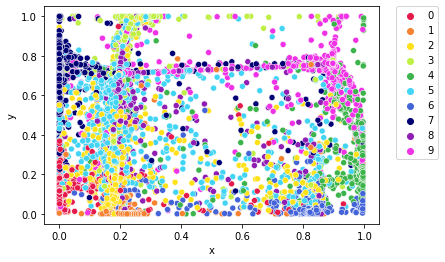

Plotting 42000 examples.


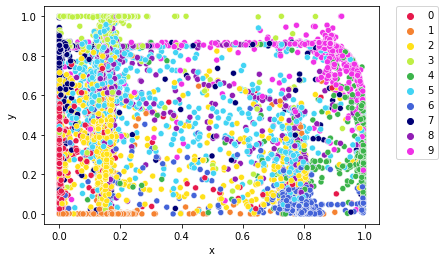

Plotting 42000 examples.


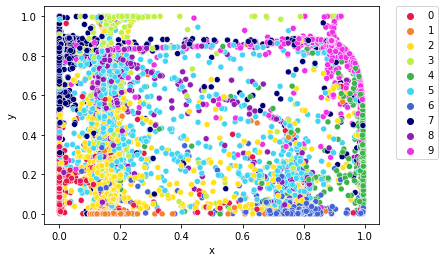

In [52]:
# Retreive latent vectors from model history

for epoch in range(0, len(model4.history['latent'])):
    # Create dataframe
    df = []
    for index, element in enumerate(model4.history['latent'][epoch]):
        vec, label = element
        df.append({'x': vec[0][0], 'y': vec[1][0], 'digit': label})
    df = pd.DataFrame(df)

    # Plot latent vectors in 2D, color-coded by digit
    print(f'Plotting {len(df)} examples.')
    colors = sns.color_palette(['#e6194B','#f58231','#ffe119','#bfef45','#3cb44b','#42d4f4','#4363d8', '#000075', '#911eb4','#f032e6'])
    sns.scatterplot(data=df, x="x", y="y", hue="digit", palette=colors);
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    # Save plot to file
    plt.savefig(f'epoch_{epoch}.png')
    plt.show();

In [7]:
# # Inspect last layer activations for training data
# last_layer = [model.feedforward(x, layer_num = 4) for x, y in train_data[:1]]
# print(last_layer[0].sum())
# print(last_layer[0])
# print(train_data[0][1])

1.381730809950103
[[1.84310775e-05]
 [6.77599952e-02]
 [1.77904862e-01]
 [8.34394325e-01]
 [1.93644048e-14]
 [1.19286716e-01]
 [1.72821332e-09]
 [5.02664849e-15]
 [1.82366479e-01]
 [1.61309401e-14]]
[[0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
